In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import LfuncN, LfuncAr, LfuncNe
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from LengyelReinkeFormulationMK import returnImpurityFracLengMK
from LengyelReinkeFormulationMKold import returnImpurityFracLengMKold
from LRBv2 import LRBv2
import os
import pickle as pkl
from timeit import default_timer as timer
import matplotlib as mpl
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF

%load_ext autoreload
%autoreload 2

fontsize = 12

plt.rc('font', size=fontsize) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize) #fontsize of the legend

def file_write(data, filename):
# Writes an object to a pickle file.
    with open(filename, "wb") as file:
    # Open file in write binary mode, dump result to file
        pkl.dump(data, file)
            
def file_read(filename):
# Reads a pickle file and returns it.
    with open(filename, "rb") as filename:
    # Open file in read binary mode, dump file to result.
        data = pkl.load(filename)
        
    return data

def make_colors(number, cmap):
    colors = []
    for i in range(number):
        colors.append(cmap(int((i * 255/number))))     
    return colors


In [3]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")


In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.05,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


    

# Impurity fraction verification

### Old code

In [8]:
c_test = dict()

In [42]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    # indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    indexRange = [30]
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0)
    out[side] = {**o, **solution} # merge dicts    
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["default"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 23.2 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 22.9 seconds


## Impurity scan

In [4]:
c_test = dict()

In [168]:
out = dict()

for side in data.keys():
    
    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    # indexRange = [30]
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "impurity_frac"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test["cz"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 21.6 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 21.6 seconds


In [44]:
file_write(results, "5-impurity_frac.pkl")

# Density scan

In [150]:
out = dict()

for side in data.keys():
    
    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "density"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test["ne"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 24.4 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 23.7 seconds


# Power scan

In [158]:
out = dict()

for side in data.keys():
    # side = "iu"
    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    # indexRange = [0, 15, 26]
    # indexRange = [28]
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "power"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test["q"] = out

Solving...0...3...7...11...15...19...23...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:54: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))


27...31...35...39...43...47...51...55...Complete in 49.1 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 52.6 seconds


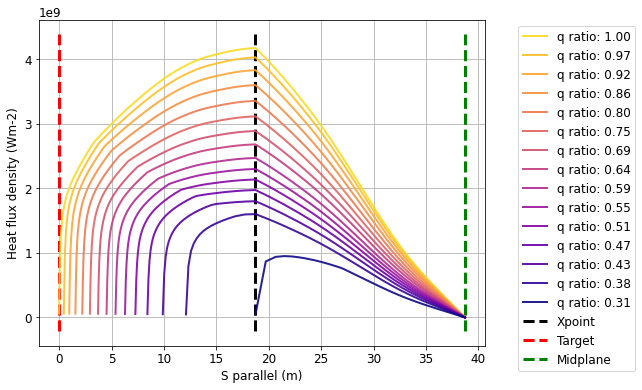

In [213]:
fig, ax = plt.subplots(figsize = (8,6))

side = "ou"
results = c_test["q"][side]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(results["indexRange"]), cmap)[::-1]

# labels = ["Front at target", "halfway", "Front at Xpoint"]
for i in range(len(results["indexRange"])):
    ax.plot(results["Sprofiles"][i], results["Qprofiles"][i], marker = "o", linewidth = 2, alpha = 0.9, markersize = 0, color = colors[i], label = "q ratio: {:.2f}".format(results["crel"][i]))
    
ylims = ax.get_ylim()

ax.vlines(data[side]["Sx"], ylims[0], ylims[1], color = "black", label = "Xpoint", linewidth = 3, linestyle = "--")
ax.vlines(data[side]["S"][0], ylims[0], ylims[1], color = "red", label = "Target", linewidth = 3, linestyle = "--")
ax.vlines(data[side]["S"][-1], ylims[0], ylims[1], color = "green", label = "Midplane", linewidth = 3, linestyle = "--")
ax.set_xlabel("S parallel (m)")
ax.set_ylabel("Heat flux density (Wm-2)")
ax.legend(bbox_to_anchor=(1.35,1))
ax.grid()

# norm = mpl.colors.BoundaryNorm(results["crel"], cmap.N, extend= "both")
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),  orientation="vertical", label = "Flux expansion ($B_{x}\//B_{t}$)")
# cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 

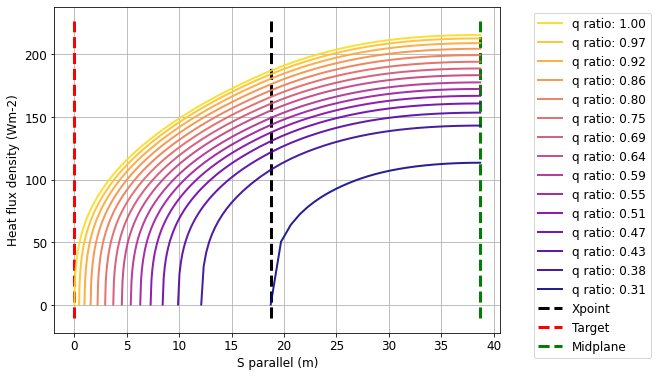

In [214]:
fig, ax = plt.subplots(figsize = (8,6))

side = "ou"
results = c_test["q"][side]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(results["indexRange"]), cmap)[::-1]

# labels = ["Front at target", "halfway", "Front at Xpoint"]
for i in range(len(results["indexRange"])):
    ax.plot(results["Sprofiles"][i], results["Tprofiles"][i], marker = "o", linewidth = 2, alpha = 0.9, markersize = 0, color = colors[i], label = "q ratio: {:.2f}".format(results["crel"][i]))
    
ylims = ax.get_ylim()

ax.vlines(data[side]["Sx"], ylims[0], ylims[1], color = "black", label = "Xpoint", linewidth = 3, linestyle = "--")
ax.vlines(data[side]["S"][0], ylims[0], ylims[1], color = "red", label = "Target", linewidth = 3, linestyle = "--")
ax.vlines(data[side]["S"][-1], ylims[0], ylims[1], color = "green", label = "Midplane", linewidth = 3, linestyle = "--")
ax.set_xlabel("S parallel (m)")
ax.set_ylabel("Heat flux density (Wm-2)")
ax.legend(bbox_to_anchor=(1.35,1))
ax.grid()

# norm = mpl.colors.BoundaryNorm(results["crel"], cmap.N, extend= "both")
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),  orientation="vertical", label = "Flux expansion ($B_{x}\//B_{t}$)")
# cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 

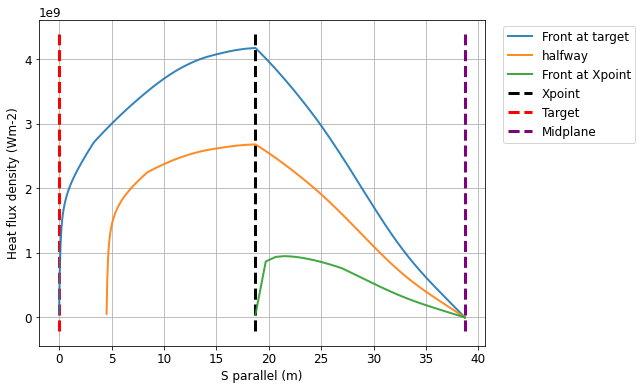

In [110]:
fig, ax = plt.subplots(figsize = (8,6))
results = c_test["q"]["ou"]

labels = ["Front at target", "halfway", "Front at Xpoint"]
for i in range(len(results["indexRange"])):
    ax.plot(results["Sprofiles"][i], results["Qprofiles"][i], marker = "o", linewidth = 2, alpha = 0.9, markersize = 0,  label = labels[i])
    
ylims = ax.get_ylim()

ax.vlines(data["ou"]["Sx"], ylims[0], ylims[1], color = "black", label = "Xpoint", linewidth = 3, linestyle = "--")
ax.vlines(data["ou"]["S"][0], ylims[0], ylims[1], color = "red", label = "Target", linewidth = 3, linestyle = "--")
ax.vlines(data["ou"]["S"][-1], ylims[0], ylims[1], color = "purple", label = "Midplane", linewidth = 3, linestyle = "--")
ax.set_xlabel("S parallel (m)")
ax.set_ylabel("Heat flux density (Wm-2)")
ax.legend(bbox_to_anchor=(1.35,1))
ax.grid()

In [50]:
data["ou"]["Xpoint"]

183

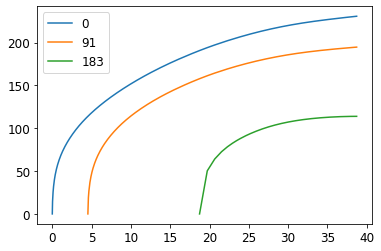

In [42]:
for i in range(len(indexRange)):
    plt.plot(c_test["q"]["ou"]["Sprofiles"][i], c_test["q"]["ou"]["Tprofiles"][i], label = indexRange[i])
plt.legend()


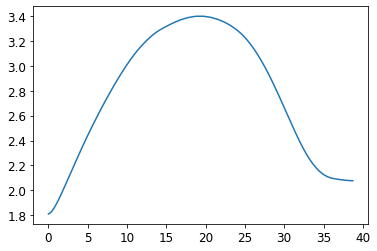

In [45]:
plt.plot(data["ou"]["S"], data["ou"]["Btot"])

In [174]:
for side in data.keys():
    c_test["q"][side]["cnorm"] = c_test["q"][side]["crel"]**(-5/7)
    c_test["cz"][side]["cnorm"] = c_test["cz"][side]["crel"]**(1/2)
    c_test["ne"][side]["cnorm"] = c_test["ne"][side]["crel"]

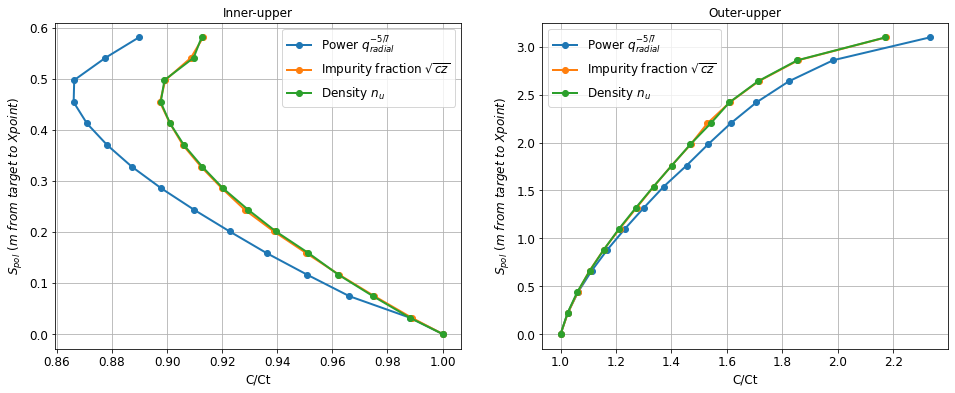

In [195]:
results = c_test
        
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")


for i, side in enumerate(data.keys()):
    d = data[side]

    out = results["q"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Power $q_{radial}^{-5/7}$", linewidth = 2, marker = "o")
    
    out = results["cz"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Impurity fraction $\sqrt{cz}$", linewidth = 2, marker = "o")
    
    out = results["ne"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Density $n_{u}$", linewidth = 2, marker = "o")
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    

for a in ax:
    a.legend(fontsize = 12)

In [ ]:
for side in data.keys():
    c_test["q"][side]["cnorm"] = c_test["q"][side]["crel"]**(-5/7)
    c_test["cz"][side]["cnorm"] = c_test["cz"][side]["crel"]**(1/2)
    c_test["ne"][side]["cnorm"] = c_test["ne"][side]["crel"]

# Different curve

In [186]:
c_test2 = dict()

In [187]:
out = dict()

for side in data.keys():
    
    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["Lfunc"] = LfuncN
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "impurity_frac"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test2["cz"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 20.5 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 20.1 seconds


# Density scan

In [188]:
out = dict()

for side in data.keys():
    
    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["Lfunc"] = LfuncN
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "density"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test2["ne"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 22.7 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 25.6 seconds


# Power scan

In [189]:
out = dict()

for side in data.keys():

    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["Lfunc"] = LfuncN
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "power"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

c_test2["q"] = out

Solving...0...3...7...11...15...19...23...27...31...35...39...43...47...51...55...Complete in 40.2 seconds
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...183...Complete in 29.4 seconds


# Comparison plot

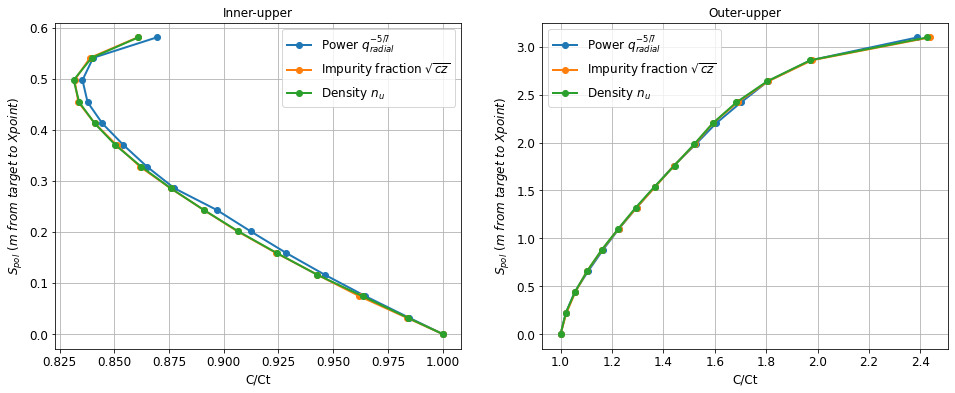

In [196]:
for side in data.keys():
    c_test2["q"][side]["cnorm"] = c_test2["q"][side]["crel"]**(-5/7)
    c_test2["cz"][side]["cnorm"] = c_test2["cz"][side]["crel"]**(1/2)
    c_test2["ne"][side]["cnorm"] = c_test2["ne"][side]["crel"]

results = c_test2
        
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")


for i, side in enumerate(data.keys()):
    d = data[side]

    out = results["q"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Power $q_{radial}^{-5/7}$", linewidth = 2, marker = "o")
    
    out = results["cz"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Impurity fraction $\sqrt{cz}$", linewidth = 2, marker = "o")
    
    out = results["ne"]
    ax[i].plot(out[side]["cnorm"], out[side]["SpolPlot"], label = "Density $n_{u}$", linewidth = 2, marker = "o")
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    

for a in ax:
    a.legend(fontsize = 12)

# Radiation profiles

- Basically take the heat sink equation from LengFunc and integrate it

In [13]:
out = dict()

for side in data.keys():

    d = data[side]

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 2).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["Lfunc"] = LfuncN
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    out[side] = LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                        control_variable = "impurity_frac"
                    )
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]



Solving...0...55...Complete in 3.0 seconds
Solving...0...183...Complete in 2.5 seconds


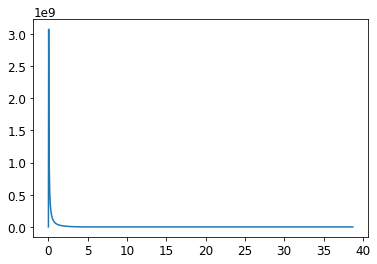

In [19]:
plt.plot(out["ou"]["Sprofiles"][0], out["ou"]["Rprofiles"][0])

In [ ]:
out["ou"]